In [1]:
%matplotlib inline
%env OMP_NUM_THREADS=10
%pylab inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 12]

import sys
sys.path.append("../")

import cv2
from matplotlib.colors import LinearSegmentedColormap

from typing import List
import random

from eclipse_fit.eclipse_estimater import *
from eclipse_fit.eclipse_optimizer import *
from eclipse_fit.utils import *

import g2o

env: OMP_NUM_THREADS=10
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# generate random data

In [2]:
num_points: int = 100

center: np.ndarray = np.array([4, 8])
A: float = 12
B: float = 2
points: List[np.array] = []

phi = 30

R = get_rot_mat_from_angle(phi/180*np.pi)

debug = []

for _ in range(num_points):
    a = random.gauss(A, 0.1)
    b = random.gauss(B, 0.1)
    angle = random.uniform(0.0, 2.0 * np.pi)
    points.append(center + R @ np.array([a * np.cos(angle), b * np.sin(angle)]))
    
    debug.append(angle)

# set optimizer

In [3]:
max_iterations: int = 200
verbose: bool = True
# TODO: Parse from command line

# Setup the optimizer
optimizer = g2o.SparseOptimizer()
solver = g2o.BlockSolverX(g2o.LinearSolverDenseX())
solver = g2o.OptimizationAlgorithmLevenberg(solver)
optimizer.set_algorithm(solver)

# Estimate eclipse roughly by svd

In [4]:
points = np.array(points)

init_angles,init_cx,init_cy,init_A,init_B,init_phi = est_eclipse_from_points(points)
print(init_cx,init_cy,init_A,init_B,init_phi / np.pi * 180)

4.455348190411247 8.218740466086276 12.25390408630732 1.9367480268668782 -149.21668359675928


# Set Factor Graph

In [5]:
eclipse: VertexEclipse = VertexEclipse()
eclipse.set_id(0)
eclipse.set_estimate([init_cx,init_cy,init_A,init_B,init_phi])  # some initial value for the circle
optimizer.add_vertex(eclipse)

True

In [6]:
# 2. add the points we measured

est_rot = get_rot_mat_from_angle(init_phi)

for i,(point, angle) in enumerate(zip(points,init_angles),1):
        
    theta: VertexTheta = VertexTheta()
    theta.set_id(i)
    theta.set_estimate([angle])
    
    #if i < 2:
    #    theta.set_fixed(True)
    
    optimizer.add_vertex(theta)

    edge: EdgePointOnEclipse = EdgePointOnEclipse()
    edge.set_information(np.identity(2))
  
    edge.set_vertex(0, eclipse)
    edge.set_vertex(1, theta)

    edge.set_measurement(point)
    # print(f"error: {edge.compute_error()}")
    # print(f"edge slots: {dir(edge)}")
    optimizer.add_edge(edge)

In [7]:
print(f"Number of vertices: {len(optimizer.vertices())}")
print(f"Number of edges: {len(optimizer.edges())}")

Number of vertices: 101
Number of edges: 100


# Execute optimization

In [8]:
# perform the optimization
optimizer.initialize_optimization()
optimizer.set_verbose(verbose)
optimizer.optimize(max_iterations)

iteration= 0	 chi2= 6.448854	 time= 0.0757638	 cumTime= 0.0757638	 edges= 100	 schur= 0	 lambda= 0.725387	 levenbergIter= 5
iteration= 1	 chi2= 5.353203	 time= 0.0601853	 cumTime= 0.135949	 edges= 100	 schur= 0	 lambda= 3.868732	 levenbergIter= 3
iteration= 2	 chi2= 4.408603	 time= 0.0529311	 cumTime= 0.18888	 edges= 100	 schur= 0	 lambda= 2.579155	 levenbergIter= 1
iteration= 3	 chi2= 4.238649	 time= 0.0651803	 cumTime= 0.254061	 edges= 100	 schur= 0	 lambda= 3.438873	 levenbergIter= 2
iteration= 4	 chi2= 3.426819	 time= 0.0668315	 cumTime= 0.320892	 edges= 100	 schur= 0	 lambda= 4.585164	 levenbergIter= 2
iteration= 5	 chi2= 2.943773	 time= 0.0568168	 cumTime= 0.377709	 edges= 100	 schur= 0	 lambda= 6.113552	 levenbergIter= 2
iteration= 6	 chi2= 2.431748	 time= 0.0544869	 cumTime= 0.432196	 edges= 100	 schur= 0	 lambda= 8.151403	 levenbergIter= 2
iteration= 7	 chi2= 2.114932	 time= 0.0546601	 cumTime= 0.486856	 edges= 100	 schur= 0	 lambda= 10.868537	 levenbergIter= 2
iteration= 8	 c

200

In [9]:
cx_est,cy_est,a_est,b_est,phi_est = optimizer.vertices()[0].estimate()

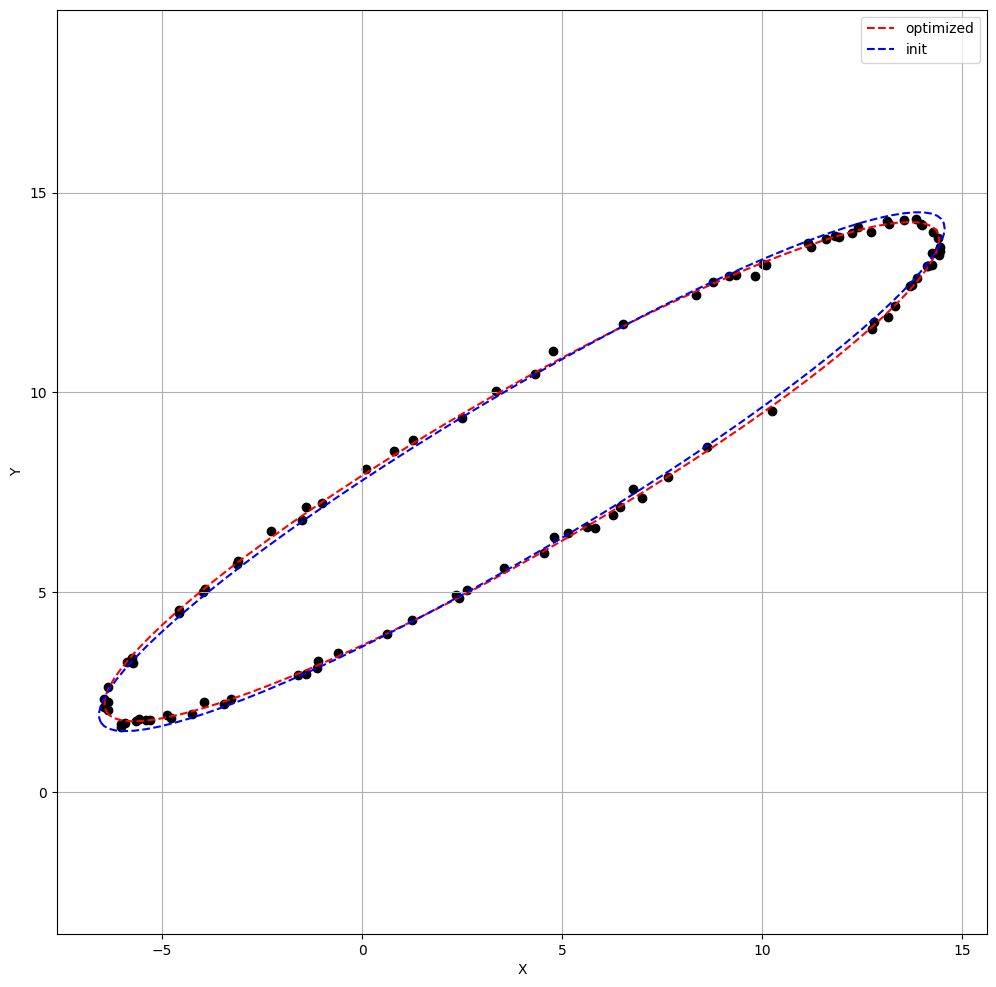

In [10]:
fix,ax =plt.subplots()

ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid(True)

def draw_eclipse(a,b,phi,c='k',label=None):

    # Generate parametric points along the ellipse
    t = np.linspace(0, 2*np.pi, 100)
    x = a * np.cos(t)
    y = b * np.sin(t)

    # Create rotation matrix
    R = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]])

    # Apply rotation transformation
    points_optim = np.dot(R, np.vstack((x, y))) + np.array([[cx_est], [cy_est]])

    # Plot the rotated ellipse
    ax.plot(points_optim[0], points_optim[1],c=c,label=label,linestyle = "dashed")

draw_eclipse(a_est,b_est,phi_est,'r','optimized')

draw_eclipse(init_A,init_B,init_phi,'b','init')

dd = np.array(points).T
ax.scatter(dd[0,:],dd[1,:],c='k')
#plt.scatter(est_eclipse_xs,est_eclipse_ys)
ax.legend()
plt.show()
